### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import sklearn
import tqdm
from tqdm import tqdm 
import nltk
import warnings
warnings.filterwarnings("ignore") 
import cv2
from sklearn.model_selection import train_test_split
import PIL
from PIL import Image
import time

import tensorflow as tf
import keras
from keras.layers import Input,Dense,Conv2D,concatenate,Dropout,LSTM
from keras import Model
from tensorflow.keras import activations
import warnings
warnings.filterwarnings("ignore")
import nltk.translate.bleu_score as bleu

In [ ]:
from google.colab import drive 
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Self Case Study 2")   

Model 1 was an enocoder- decoder model. where enocder is used to extract the image features and decoder is used to generate the corresponding medical report.

Here we extract the image features using CheXNet model itself.
Now,instead of giving this features directly to the decoder model we perform some attention mechanism on the image features. Now, to the decoder, we give the context vector we obtained after attention which contains the relative importance of image regions. So based on this context vector the decoder generate the most apppropriate word.

## CheXnet Model

The output required from the chexnet model is a flattened vector of size 1048. So we used pooling ="avg". This will create a global average pooling layer as the final layer. 

In [ ]:
'''
First we need to load the chexnet nodel (DenseNet121),
The trained weight of this model is from https://github.com/brucechou1983/CheXNet-Keras

'''
#https://github.com/antoniosehk/tCheXNet/blob/master/chexnet.py
from tensorflow.keras.applications import DenseNet121

image_shape= (224,224,3)
image_input= Input(shape=(224,224,3))

base=DenseNet121(include_top=False,input_tensor=image_input,input_shape=image_shape,pooling="avg")
pred=Dense(14,"sigmoid")(base.output)

chexnet_model=Model(inputs=base.input,outputs=pred)
chexnet_model.load_weights("chexnet_weights.h5")

chexnet_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________

We have loaded the pre-trained chexnet model. Now we don't need the whole model. So we remove the last layer, and we take the output from the second last layer and consider it as the image features

In [ ]:
final_chexnet_model=Model(inputs=chexnet_model.inputs,outputs=chexnet_model.layers[-2].output,name="Chexnet_model")  

### Read the data containing image paths and reports

In [ ]:
#first we split the data set into train and test data sets
train=pd.read_csv("train")
test=pd.read_csv("test")

In [ ]:
# test.to_csv("test")
# train.to_csv("train")

In [ ]:
'''
Obtaining the image feature for every patient using the final chexnet model which we had build earlier.
Here we pass two images. Now we predict the 7,7,1024 dimensional vector for each image from the final chexnet model.
Now we need to concatenate these features. Here we conatenate these features along the width and then we will get a 7,14,1024 dimensional vector after 
cocatenation. Now to perform the attention mechansm we convert this into (7x14),1024 i.e, 96,1024 dimensional tensor. So there will be 96 regions 
in the image with a depth of 1024.
'''

def image_feature_extraction(image1,image2):
  
 
  image_1 = Image.open(image1)
  
  image_1= np.asarray(image_1.convert("RGB"))
  
  
  image_2=Image.open(image2)
  image_2 = np.asarray(image_2.convert("RGB"))

    #normalize the values of the image
  image_1=image_1/255
  image_2=image_2/255

    #resize all image into (224,224)
  image_1 = cv2.resize(image_1,(224,224))
  image_2 = cv2.resize(image_2,(224,224))
    
  image_1= np.expand_dims(image_1, axis=0)
  image_2= np.expand_dims(image_2, axis=0)
    
    #now we have read two image per patient. this is goven to the chexnet model for feature extraction
    
  image_1_out=final_chexnet_model(image_1)
  image_2_out=final_chexnet_model(image_2)
  #conactenate along the width
  conc=np.concatenate((image_1_out,image_2_out),axis=-1)
  #reshape into(no.of images passed, length*breadth, depth)
  image_feature=tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))
  

  
  return image_feature

In [ ]:
# train_features=np.zeros((3056,98,1024))
# test_features=np.zeros((764,98,1024))

# for row in tqdm(range(train.shape[0])):
#   image_1=train.iloc[row]["image1"]
#   image_2=train.iloc[row]["image2"]
#   train_features[row]=(image_feature_extraction(image_1,image_2))


In [ ]:
# for row in tqdm(range(test.shape[0])):
#   image_1=test.iloc[row]["image1"] 
#   image_2=test.iloc[row]["image2"]
#   test_features[row]=(image_feature_extraction(image_1,image_2)) 

In [ ]:
# np.save("train_features_attention",train_features)
# np.save("test_features_attention",test_features)

In [ ]:
train_features=np.load("train_features_attention1.npy")
test_features=np.load("test_features_attention1.npy")  

In [ ]:
k=19
print(test_features[k])
one=test.iloc[k]["image1"] 
two=test.iloc[k]["image2"]
print(image_feature_extraction(one,two))  

[[1.56956870e-04 2.28554918e-03 2.48678494e-03 ... 8.21624577e-01
  8.54204059e-01 6.74322248e-01]]
tf.Tensor(
[[[1.5695687e-04 2.2855492e-03 2.4867849e-03 ... 8.2162458e-01
   8.5420406e-01 6.7432225e-01]]], shape=(1, 1, 2048), dtype=float32)


In [ ]:
print(train_features.shape)
print(test_features.shape) 

(3056, 1, 2048)
(764, 1, 2048)


In [ ]:
'''
Modify the reports as <sos> report text <eos>. This format is useful for the decoder while predicting the next word
'''

train_report=["<sos> "+text+" <eos>" for text in train["report"].values]
train_report_in=["<sos> "+text for text in train["report"].values]
train_report_out=[text+" <eos>" for text in train["report"].values]

test_report=["<sos> " +text+" <eos>" for text in test["report"].values]
test_report_in=["<sos> " +text for text in test["report"].values]
test_report_out=[text+" <eos>" for text in test["report"].values]  

In [ ]:
print(train_report_in[0])
print("*"*100)
print(train_report_out[0])

<sos> cardiomediastinal silhouettes are within normal limits. lungs are clear without focal consolidation pneumothorax pleural effusion. bony thorax unremarkable. 
****************************************************************************************************
cardiomediastinal silhouettes are within normal limits. lungs are clear without focal consolidation pneumothorax pleural effusion. bony thorax unremarkable.  <eos>


In [ ]:
bs=10
max_len=80

In [ ]:
#Obtaining the text embeddings of the report
# we use the tensorflow tokenizer to convert the text into tokens
#we also pad the sequences to a length 300 which is around the 90th percentile of the lengths of the report

token=tf.keras.preprocessing.text.Tokenizer(filters='' )

token.fit_on_texts(train_report)
vocab_size=len(token.word_index)+1 

seq=token.texts_to_sequences(train_report_in)
train_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(train_report_out)
train_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

seq=token.texts_to_sequences(test_report_in)
test_padded_inp=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")


seq=token.texts_to_sequences(test_report_out)
test_padded_out=tf.keras.preprocessing.sequence.pad_sequences(seq,maxlen=max_len,padding="post")

In [ ]:
# #now we prepare the data set with the image fetaures and the reports
# train_dataset = tf.data.Dataset.from_tensor_slices((train_features,train_padded_inp,train_padded_out)).shuffle(500)
# train_dataset = train_dataset.batch(bs, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((test_features,test_padded_inp,test_padded_out)).shuffle(500)
# test_dataset = test_dataset.batch(bs,drop_remainder=True) 


In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embeddings_index=dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print("Done")
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tqdm(token.word_index.items()):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector 


100%|██████████| 2016/2016 [00:00<00:00, 262412.47it/s]

Done


### Model with attention

1. We extract image features from feature extraction module

2. Now we pass this to encoder model which gives the encoder outputs

3. For the decoder model,


*   First we pass the decoder hidden state and encoder output to the attention model which calculate the attention weights
*   Now using the attention weights and encoder output we calculate the context vector

*   Now we take the context vector and embedding vector of decoder input and conncatenate this to a vector
*   Now we take this concatenated vector and pass it to the gru

*   Then the gru output is passed to the final dense layer








In [ ]:
enc_units=64
embedding_dim=300
dec_units=64
att_units=64


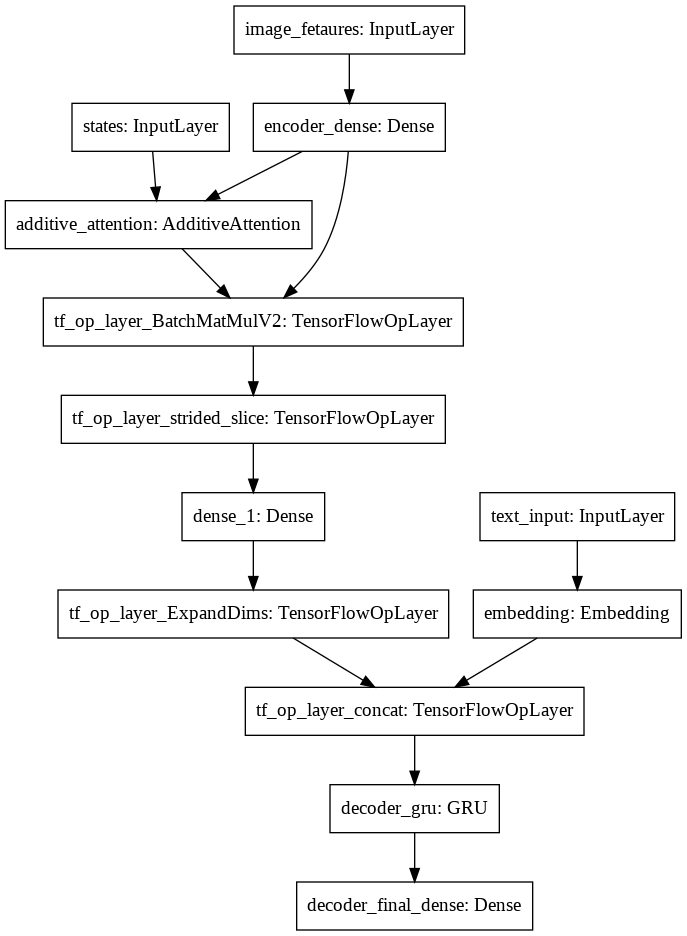

In [ ]:
input_img=Input(shape=(2048),name="image_fetaures")
input_txt=Input(shape=(max_len),name="text_input")

#encoder model
en_out=Dense(enc_units,activation="relu",name="encoder_dense")(input_img)
enc_out=tf.keras.layers.Dropout(0.5)(en_out)

state_h= Input(shape=(bs,enc_units),name="states")
#decoder model with attention

emb_out=tf.keras.layers.Embedding(vocab_size,output_dim=300,input_length=max_len,mask_zero=True,trainable=False,weights=[embedding_matrix])(input_txt)
weights=tf.keras.layers.AdditiveAttention()([state_h,en_out])
context_vector=tf.matmul(en_out,weights,transpose_a=True)[:,:,0]
context_vector=Dense(embedding_dim)(context_vector)
result=tf.concat([tf.expand_dims(context_vector, axis=1),emb_out],axis=1)
gru_out,state=tf.keras.layers.GRU(dec_units,return_sequences=True,return_state=True,name="decoder_gru")(result)
out=tf.keras.layers.Dense(vocab_size,name="decoder_final_dense") (gru_out)
en_de=Model(inputs=[input_txt,input_img,state_h],outputs=out)

keras.utils.plot_model(en_de)

Defining encoder, decoder and attention classes

In [ ]:
#encoder model
'''
here the input will be image features with size (96,1024). We can consider this tensor as the encoder output.
But here we add another dense layer that will reduce the depth of this feature from 1024 to a low value
'''

class Encoder(tf.keras.Model):
  def __init__(self,units):
    super().__init__()
    self.units=units
    
  
  def build(self,input_shape):
    self.dense1=Dense(self.units,activation="relu",kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 0),name="encoder_dense")
    self.maxpool=tf.keras.layers.Dropout(0.5)

  def call(self,input_):
    enc_out=self.maxpool(input_)
    enc_out=self.dense1(enc_out) 
    
    return enc_out
    
  def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state
      If batch size is 32- Hidden state shape is [32,units]
      '''
      hidden=tf.zeros((batch_size,self.units))
      
      return hidden 


In [ ]:
'''
this is the attention class. 
Here the input to the decoder and the gru hidden state at the pevious time step are given, and the context vector is calculated

This context vector is calculated uisng the attention weights. This context vector is then passed to the decoder model

Here conact function is used for calaculating the attention weights

'''

class Attention(tf.keras.layers.Layer):

  def __init__(self,att_units):

    super().__init__()
    
    self.att_units=att_units

  def build(self,input_shape):
    self.wa=tf.keras.layers.Dense(self.att_units)
    self.wb=tf.keras.layers.Dense(self.att_units)
    self.v=tf.keras.layers.Dense(1)
  
    
  def call(self,decoder_hidden_state,encoder_output):
   
    x=tf.expand_dims(decoder_hidden_state,1)
    
    # print(x.shape)
    # print(encoder_output.shape)
      
    alpha_dash=self.v(tf.nn.tanh(self.wa(encoder_output)+self.wb(x)))
    
    alphas=tf.nn.softmax(alpha_dash,1)

    # print("en",encoder_output.shape)
    # print("al",alphas.shape)
    
    context_vector=tf.matmul(encoder_output,alphas,transpose_a=True)[:,:,0]
    # context_vector = alphas*encoder_output
    # print("c",context_vector.shape)


    return (context_vector,alphas)
        
        
    
    

In [ ]:
'''
This class will perform the decoder task.
The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput 
at time step t.
This output is passed through the final softmax layer with output size =vocab size, and pass this result to the main decoder model

'''

class One_Step_Decoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, input_length, dec_units ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()
    
    self.att_units=att_units
    self.vocab_size=vocab_size
    self.embedding_dim=embedding_dim
    self.input_length=input_length
    
    self.dec_units=dec_units
    self.attention=Attention(self.att_units)
  #def build(self,inp_shape):
    self.embedding=tf.keras.layers.Embedding(self.vocab_size,output_dim=self.embedding_dim,
                                             input_length=self.input_length,mask_zero=True,trainable=False,weights=[embedding_matrix])

    self.gru=tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform',name="decoder_gru")
    self.dense=tf.keras.layers.Dense(self.vocab_size,name="decoder_final_dense")
    self.dense_2=tf.keras.layers.Dense(self.embedding_dim,name="decoder_dense2") 
    
  def call(self,input_to_decoder, encoder_output, state_h):
    
    embed=self.embedding(input_to_decoder)
    
    context_vector,alpha=self.attention(state_h,encoder_output)
    context_vector = self.dense_2(context_vector)
    
    result=tf.concat([tf.expand_dims(context_vector, axis=1),embed],axis=-1)
    
   
    output,decoder_state_1=self.gru(result,initial_state=state_h)
    out=tf.reshape(output,(-1,output.shape[-1]))

    
    
    dense_op=self.dense(out)
    dense_op=self.dense_2(dense_op)
    
    return dense_op,decoder_state_1,alpha

In [ ]:
'''
For every input sentence, each output word is generated using one step decoder. Each output word is stored using the final decoder model and the
final output sentence is returned

'''

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, output_length, dec_units,att_units):
      super().__init__()
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestep=One_Step_Decoder(vocab_size, embedding_dim, output_length, dec_units,att_units)


        
    def call(self, input_to_decoder,encoder_output,state_1):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        all_outputs=tf.TensorArray(tf.float32,input_to_decoder.shape[1],name="output_array")
        for step in range(input_to_decoder.shape[1]):
          output,state_1,alpha=self.onestep(input_to_decoder[:,step:step+1],encoder_output,state_1)

          all_outputs=all_outputs.write(step,output)
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs
    

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,enc_units,embedding_dim,vocab_size,output_length,dec_units,att_units,batch_size):
        super().__init__()

        
        self.batch_size=batch_size
        self.encoder =Encoder(enc_units)
        self.decoder=Decoder(vocab_size,embedding_dim,output_length,dec_units,att_units)
        
  
    #Coompute the image features using feature extraction model and pass it to the encoder
    # This will give encoder ouput
   # Pass the decoder sequence,encoder_output,initial states to Decoder
    # return the decoder output

  
  def call(self, data):
        features,report  = data[0], data[1]
        
        encoder_output= self.encoder(features)
        state_h=self.encoder.initialize_states(self.batch_size)
        
        output= self.decoder(report, encoder_output,state_h)
      
        return output

    
      

In [ ]:

model  = encoder_decoder(enc_units,embedding_dim,vocab_size,max_len,dec_units,att_units,bs)


In [ ]:

optimizer = tf.keras.optimizers.Adam()

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='auto')

def custom_lossfunction(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:


model.compile(optimizer=optimizer,loss=custom_lossfunction)


In [ ]:
red_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2, min_lr=0.0001)
ckpt=tf.keras.callbacks.ModelCheckpoint("model2wts/ckpt",monitor='val_loss', verbose=0, save_best_only=True,save_weights_only=False, mode='auto')

In [ ]:
model.fit([train_features[:3050],train_padded_inp[:3050]],train_padded_out[:3050],validation_data=([test_features[:760],test_padded_inp[:760]],test_padded_out[:760]),
          batch_size=bs,epochs=10,callbacks=[red_lr,ckpt]) 


Epoch 1/10
305/305 [==============================] - 47s 153ms/step - loss: 0.8865 - val_loss: 0.6265
Epoch 2/10
305/305 [==============================] - 35s 113ms/step - loss: 0.5633 - val_loss: 0.5051
Epoch 3/10
305/305 [==============================] - 32s 106ms/step - loss: 0.4666 - val_loss: 0.4316
Epoch 4/10
305/305 [==============================] - 33s 107ms/step - loss: 0.4112 - val_loss: 0.3914
Epoch 5/10
305/305 [==============================] - 32s 106ms/step - loss: 0.3760 - val_loss: 0.3639
Epoch 6/10
305/305 [==============================] - 35s 116ms/step - loss: 0.3501 - val_loss: 0.3448
Epoch 7/10
305/305 [==============================] - 33s 108ms/step - loss: 0.3284 - val_loss: 0.3282
Epoch 8/10
305/305 [==============================] - 32s 106ms/step - loss: 0.3112 - val_loss: 0.3166
Epoch 9/10
305/305 [==============================] - 32s 105ms/step - loss: 0.2991 - val_loss: 0.3072
Epoch 10/10
305/305 [==============================] - 32s 106ms/step - l

In [ ]:
model.load_weights("model2wts/fit_10_b")


In [ ]:
import time

### Evaluation using greedy search

In [ ]:
def evaluate(image1,image2):
  
  curr=tf.constant([[token.word_index['<sos>']]])
  # curr= np.array([token.word_index['<sos>']]).reshape(1,1)

  features=image_feature_extraction(image1,image2)

  h= tf.zeros((1,enc_units))

  en_output= model.layers[0].predict(features)
  
  pred=[]
  for i in range(max_len):
    out,h,alpha=model.layers[1].onestep(curr,en_output,h)
    
    k=tf.argmax(out[0])

    curr=np.reshape(k,(1,1))
    
    pred.append(token.index_word[curr[0][0]])
    if token.index_word[curr[0][0]]=="<eos>":
      break
 
  predi=""               
  for j in pred:
    predi+=j+" "
 
  
  return predi


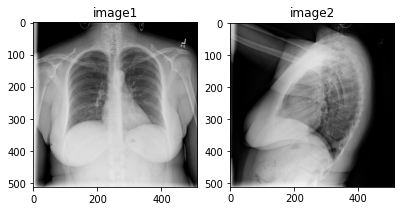

ACTUAL REPORT:  <sos> the lungs are clear. there pleural effusion pneumothorax. the heart and mediastinum are normal. the skeletal structures are normal.  <eos>
GENERATED REPORT:  the heart size and pulmonary vascularity appear within normal limits. the lungs are clear. there pleural effusion pneumothorax. <eos> 
BLEU SCORE IS:  0.6365455268683196
time required for the evaluation is  1.3581409454345703


In [ ]:
start=time.time()
import random 
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result=evaluate(img1,img2) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result) 
end=time.time()
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
print("time required for the evaluation is ",end-start)

In [ ]:
#compute average bleu score for test data
start=time.time()
index=range(0,test.shape[0])
bl=0
for i in (index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result=evaluate(img1,img2) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(actual,result)
end=time.time()
print("\n")
print("average bleu score on the test data is ",bl/test.shape[0])





average bleu score on the test data is  0.6514907322500497


In [ ]:
print("average time taken for evaluation is ",(end-start)/764,"seconds")

average time taken for evaluation is  0.833292394720447 seconds


The above method for prediction used greedy search algorithm were the model predicts the most likely outcome as the output. Instead of that we try beam seach algorithm. Here in each time step, the model predicts k likely outcomes possible

### Evaluation using Beam search

In [ ]:
def take_second(elem):
    return elem[1]

In [ ]:
#beam search algorithm


def beam_search(image1,image2, beam_index):

    hidden_state =  tf.zeros((1, enc_units))

    image_features=image_feature_extraction(image1,image2)

    encoder_out = model.layers[0](image_features)

    start_token = [token.word_index["<sos>"]]
    dec_word = [[start_token, 0.0]]
    while len(dec_word[0][0]) < max_len:
        temp = []
        for word in dec_word:
            
            predict, hidden_state,alpha = model.layers[1].onestep(tf.expand_dims([word[0][-1]],1), encoder_out, hidden_state)
           
            word_predict = np.argsort(predict[0])[-beam_index:]
            for i in word_predict:

                next_word, probab = word[0][:], word[1]
                next_word.append(i)
                probab += predict[0][i]
                temp.append([next_word, probab.numpy()])
        dec_word = temp
        # Sorting according to the probabilities scores
        
        
        dec_word = sorted(dec_word, key=take_second)
       
        # Getting the top words
        dec_word = dec_word[-beam_index:] 
        
     
    final = dec_word[-1]
    
    report =final[0]
    score = final[1]
    temp = []
    
    for word in report:
      if word!=0:
        if word != token.word_index['<eos>']:
            temp.append(token.index_word[word])
        else:
            break 

    rep = ' '.join(e for e in temp)        
    
    return rep, score

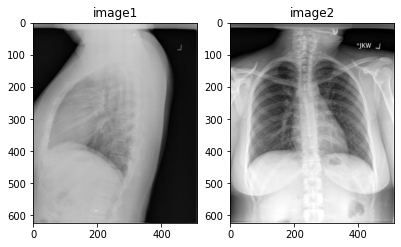

ACTUAL REPORT:  <sos> the heart normal size. the mediastinum unremarkable. the lungs are clear. evidence active tuberculosis.  <eos>
GENERATED REPORT:  <sos> heart size and lateral views the heart size and mediastinal contour within normal pulmonary are within normal limits.
BLEU SCORE IS:  0.6350109599627048
time required for the evaluation is  2.5351548194885254


In [ ]:
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result)
end=time.time() 
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))

print("time required for the evaluation is ",end-start)

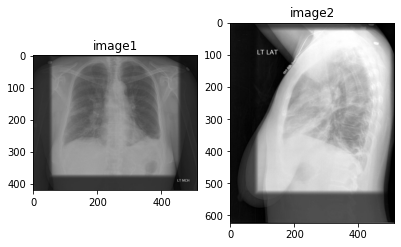

ACTUAL REPORT:  <sos> bibasilar airspace opacities right greater than left. the heart size and mediastinal silhouette are within normal limits for contour. pneumothorax pleural effusions. the are intact.  <eos>
GENERATED REPORT:  <sos> heart size and lateral views the heart size and mediastinal contours are within normal pulmonary edema.
BLEU SCORE IS:  0.6625187887633293
time required for the evaluation is  2.5277726650238037


In [ ]:
import random 
start=time.time()
i=random.sample(range(test.shape[0]),1)[0]
img1=test.iloc[i]["image1"]
img2=test.iloc[i]["image2"]
  #show th corresponding x-ray images
i1=cv2.imread(img1)
i2=cv2.imread(img2)
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.title("image1")
plt.imshow(i1)
plt.subplot(132)
plt.title("image2")
plt.imshow(i2)
plt.show()
  #printing the actual and generated results
  
result,score=beam_search(img1,img2,3) 
actual=test_report[i]
  
print("ACTUAL REPORT: ",actual)
print("GENERATED REPORT: ",result) 
end=time.time()
print("BLEU SCORE IS: ",bleu.sentence_bleu(actual,result))
print("time required for the evaluation is ",end-start)


We can see the results are improved when beam search was used. The time of execution for beam search is more than greedy search. However, this will balance with the accuracy of results

In [ ]:
#compute average bleu score for test data using bleu score
index=range(0,test.shape[0])
bl=0
for i in (index):
  img1=test.iloc[i]["image1"]
  img2=test.iloc[i]["image2"]
  result,score=beam_search(img1,img2,3) 
  actual=test_report[i]
  bl+=bleu.sentence_bleu(actual,result)

print("\n")
print("average bleu score on the test data is ",bl/test.shape[0])





average bleu score on the test data is  0.6671849412787869


We can see that this method didn't give much improved results. This might be because we used average pooling in the chexnet model and ignored all spatial information. The attention mechansim didn't add any improvement here. So we need to try without using average pooling in the coming models

**OBSERVATIONS:** This model used attention mechansim and gave good results as compared to model 1(baseline model)

However, when greedy search was used, the predictions were not very good. Use of beam search improve the results.

The time taken for prediction is greater for beam search, when compared to the greedy search method

**NOTES**
Next we try to obtain the spatial information of x-rays from the chexnet model. We perform the attention mechanism in this output.

Now we need to try beam search agorithm in this attention based model. 